<a href="https://colab.research.google.com/github/jonbaer/googlecolab/blob/master/Planning_feature_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Search Planning - does your proposed new feature add information to the ranking function?

Planning relevance experiments usually means conversations about "adding an item to the index to match on" or "parsing out a new attribute of the query" or "new way of query-document similarity". What we'll call a new **feature** in the ranking function.

Note even a complicated API, with lots of conditional branches, etc is still a "ranking function".

This notebook helps us answer two questions

1. Does the new feature **add information** that existing features do not have? (If not, it may not be worth pursuing)
2. Does the new feature **improve pairwise accuracy** between relevant / irrelevant docs? Does it improve relevance and make it easier for a classifier to tell the difference between relevant / irrelevant documents?
3. How does the new feature **explain prediction values**? If we increase accuracy, add new information, is the prediction used?

We don't need to be deploying machine learning for ranking just to use ML to help answer these questions and help us better plan.

## Setup

### Download the WANDS e-commerce search dataset

[WANDS is a dataset from Wayfair](https://github.com/wayfair/WANDS) for search experimentation

In [ ]:
!git clone https://github.com/wayfair/WANDS.git
!ls WANDS/dataset

Cloning into 'WANDS'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 40 (delta 7), reused 23 (delta 3), pack-reused 0
Receiving objects: 100% (40/40), 33.32 MiB | 8.80 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (19/19), done.
label.csv  product.csv	query.csv


### Install dependencies

* SearchArray - a BM25 index
* Pystemmer - for simple stemming
* openai - for openai API access

In [ ]:
!pip install SearchArray==0.0.57 pystemmer openai shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
  Created wheel for SearchArray: filename=searcharray-0.0.57-cp310-cp310-linux_x86_64.whl size=2789929 sha256=7dacea5d1d5282cc2f61e9203bf5d12087266a2bf61c615e5346b5605666d5b1
  Stored in directory: /root/.cache/pip/wheels/04/58/ac/4391a14b427a50300cfbd0ca20d

In [ ]:
import pandas as pd
import numpy as np
import Stemmer
import string
from searcharray import SearchArray

### Load WANDS dataset

In [ ]:
products = pd.read_csv("WANDS/dataset/product.csv",
                       delimiter="\t")
queries = pd.read_csv("WANDS/dataset/query.csv",
                       delimiter="\t")
labels = pd.read_csv("WANDS/dataset/label.csv",
                      delimiter="\t")

In [ ]:
products

,product_id,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0
...,...,...,...,...,...,...,...,...,...
42989,42989,malibu pressure balanced diverter fixed shower...,Shower Panels,Home Improvement / Bathroom Remodel & Bathroom...,the malibu pressure balanced diverter fixed sh...,producttype : shower panel|spraypattern : rain...,3.0,4.5,2.0
42990,42990,emmeline 5 piece breakfast dining set,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dinin...,NaN,basematerialdetails : steel| : gray wood|ofhar...,1314.0,4.5,864.0
42991,42991,maloney 3 piece pub table set,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dinin...,this pub table set includes 1 counter height t...,additionaltoolsrequirednotincluded : power dri...,49.0,4.0,41.0
42992,42992,fletcher 27.5 '' wide polyester armchair,Teen Lounge Furniture|Accent Chairs,Furniture / Living Room Furniture / Chairs & S...,"bring iconic , modern style to your space in a...",legmaterialdetails : rubberwood|backheight-sea...,1746.0,4.5,1226.0


In [ ]:
queries

,query_id,query,query_class
0,0,salon chair,Massage Chairs
1,1,smart coffee table,Coffee & Cocktail Tables
2,2,dinosaur,Kids Wall Décor
3,3,turquoise pillows,Accent Pillows
4,4,chair and a half recliner,Recliners
...,...,...,...
475,483,rustic twig,Faux Plants and Trees
476,484,nespresso vertuo next premium by breville with...,Espresso Machines
477,485,pedistole sink,Kitchen Sinks
478,486,54 in bench cushion,Furniture Cushions


In [ ]:
labels
labels.loc[labels['label'] == 'Exact', 'grade'] = 2
labels.loc[labels['label'] == 'Partial', 'grade'] = 1
labels.loc[labels['label'] == 'Irrelevant', 'grade'] = 0
labels

,id,query_id,product_id,label,grade
0,0,0,25434,Exact,2.0
1,1,0,12088,Irrelevant,0.0
2,2,0,42931,Exact,2.0
3,3,0,2636,Exact,2.0
4,4,0,42923,Exact,2.0
...,...,...,...,...,...
233443,234010,478,15439,Partial,1.0
233444,234011,478,451,Partial,1.0
233445,234012,478,30764,Irrelevant,0.0
233446,234013,478,16796,Partial,1.0


In [ ]:
judgments = labels.merge(queries, on='query_id', how='left')
judgments

,id,query_id,product_id,label,grade,query,query_class
0,0,0,25434,Exact,2.0,salon chair,Massage Chairs
1,1,0,12088,Irrelevant,0.0,salon chair,Massage Chairs
2,2,0,42931,Exact,2.0,salon chair,Massage Chairs
3,3,0,2636,Exact,2.0,salon chair,Massage Chairs
4,4,0,42923,Exact,2.0,salon chair,Massage Chairs
...,...,...,...,...,...,...,...
233443,234010,478,15439,Partial,1.0,worn leather office chair,Office Chairs
233444,234011,478,451,Partial,1.0,worn leather office chair,Office Chairs
233445,234012,478,30764,Irrelevant,0.0,worn leather office chair,Office Chairs
233446,234013,478,16796,Partial,1.0,worn leather office chair,Office Chairs


### Generate downsample

We're just hunting for promising ideas worth investing, not going deep into any one investigation.

In [ ]:
merged = labels.merge(products, on="product_id", how="inner")
downsample = merged.groupby('product_id').first().reset_index()
downsample

,product_id,id,query_id,label,grade,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,17882,125,Partial,1.0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,8012,62,Exact,2.0,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,8013,62,Partial,1.0,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,39248,368,Exact,2.0,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,9635,76,Irrelevant,0.0,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42981,42989,34762,294,Partial,1.0,malibu pressure balanced diverter fixed shower...,Shower Panels,Home Improvement / Bathroom Remodel & Bathroom...,the malibu pressure balanced diverter fixed sh...,producttype : shower panel|spraypattern : rain...,3.0,4.5,2.0
42982,42990,44055,421,Exact,2.0,emmeline 5 piece breakfast dining set,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dinin...,None,basematerialdetails : steel| : gray wood|ofhar...,1314.0,4.5,864.0
42983,42991,32248,258,Exact,2.0,maloney 3 piece pub table set,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dinin...,this pub table set includes 1 counter height t...,additionaltoolsrequirednotincluded : power dri...,49.0,4.0,41.0
42984,42992,5808,45,Exact,2.0,fletcher 27.5 '' wide polyester armchair,Teen Lounge Furniture|Accent Chairs,Furniture / Living Room Furniture / Chairs & S...,"bring iconic , modern style to your space in a...",legmaterialdetails : rubberwood|backheight-sea...,1746.0,4.5,1226.0


### Index downsample

The sort of lexical indexing we would do in a search engine like Solr or Elasticsearch

In [ ]:
stemmer = Stemmer.Stemmer('english', maxCacheSize=0)

fold_to_ascii = dict([(ord(x), ord(y)) for x, y in zip(u"‘’´“”–-", u"'''\"\"--")])
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})
all_trans = {**fold_to_ascii, **punct_trans}


def stem_word(word):
    return stemmer.stemWord(word)


def snowball_tokenizer(text):
    if type(text) == float:
        return ''
    if text is None:
        return ''
    text = text.translate(all_trans).replace("'", " ")
    split = text.lower().split()
    return [stem_word(token)
            for token in split]


def ws_tokenizer(text):
    if text is None:
        return ''
    text = text.translate(all_trans)
    split = text.lower().split()
    return split

In [ ]:
downsample['product_name_snowball'] = SearchArray.index(downsample['product_name'],
                                                        tokenizer=snowball_tokenizer)
downsample['product_description_snowball'] = SearchArray.index(downsample['product_description'],
                                                               tokenizer=snowball_tokenizer)
downsample['product_class_snowball'] = SearchArray.index(downsample['product_class'],
                                                         tokenizer=snowball_tokenizer)

downsample['product_name_ws'] = SearchArray.index(downsample['product_name'],
                                                  tokenizer=ws_tokenizer)
downsample['product_description_ws'] = SearchArray.index(downsample['product_description'],
                                                         tokenizer=ws_tokenizer)
downsample['product_class_ws'] = SearchArray.index(downsample['product_class'],
                                                   tokenizer=ws_tokenizer)

2024-06-14 07:57:06,939 - searcharray.indexing - INFO - Indexing begins


INFO:searcharray.indexing:Indexing begins


2024-06-14 07:57:06,961 - searcharray.indexing - INFO - 0 Batch Start tokenization


INFO:searcharray.indexing:0 Batch Start tokenization


2024-06-14 07:57:06,965 - searcharray.indexing - INFO - Tokenizing 42986 documents


INFO:searcharray.indexing:Tokenizing 42986 documents


2024-06-14 07:57:07,515 - searcharray.indexing - INFO - Tokenized 10000 (23.26338807983995%)


INFO:searcharray.indexing:Tokenized 10000 (23.26338807983995%)


2024-06-14 07:57:08,292 - searcharray.indexing - INFO - Tokenized 20000 (46.5267761596799%)


INFO:searcharray.indexing:Tokenized 20000 (46.5267761596799%)


2024-06-14 07:57:09,039 - searcharray.indexing - INFO - Tokenized 30000 (69.79016423951985%)


INFO:searcharray.indexing:Tokenized 30000 (69.79016423951985%)


2024-06-14 07:57:09,833 - searcharray.indexing - INFO - Tokenized 40000 (93.0535523193598%)


INFO:searcharray.indexing:Tokenized 40000 (93.0535523193598%)


2024-06-14 07:57:10,321 - searcharray.indexing - INFO - Tokenization -- vstacking


INFO:searcharray.indexing:Tokenization -- vstacking


2024-06-14 07:57:10,551 - searcharray.indexing - INFO - Tokenization -- DONE


INFO:searcharray.indexing:Tokenization -- DONE


2024-06-14 07:57:10,569 - searcharray.indexing - INFO - Inverting docs->terms


INFO:searcharray.indexing:Inverting docs->terms


2024-06-14 07:57:10,739 - searcharray.indexing - INFO - Encoding positions to bit array


INFO:searcharray.indexing:Encoding positions to bit array


2024-06-14 07:57:10,859 - searcharray.indexing - INFO - Indexing from tokenization complete


INFO:searcharray.indexing:Indexing from tokenization complete


2024-06-14 07:57:10,915 - searcharray.indexing - INFO - Indexing begins


INFO:searcharray.indexing:Indexing begins


2024-06-14 07:57:10,955 - searcharray.indexing - INFO - 0 Batch Start tokenization


INFO:searcharray.indexing:0 Batch Start tokenization


2024-06-14 07:57:10,966 - searcharray.indexing - INFO - Tokenizing 42986 documents


INFO:searcharray.indexing:Tokenizing 42986 documents


2024-06-14 07:57:15,581 - searcharray.indexing - INFO - Tokenized 10000 (23.26338807983995%)


INFO:searcharray.indexing:Tokenized 10000 (23.26338807983995%)


2024-06-14 07:57:19,110 - searcharray.indexing - INFO - Tokenized 20000 (46.5267761596799%)


INFO:searcharray.indexing:Tokenized 20000 (46.5267761596799%)


2024-06-14 07:57:22,448 - searcharray.indexing - INFO - Tokenized 30000 (69.79016423951985%)


INFO:searcharray.indexing:Tokenized 30000 (69.79016423951985%)


2024-06-14 07:57:28,296 - searcharray.indexing - INFO - Tokenized 40000 (93.0535523193598%)


INFO:searcharray.indexing:Tokenized 40000 (93.0535523193598%)


2024-06-14 07:57:29,939 - searcharray.indexing - INFO - Tokenization -- vstacking


INFO:searcharray.indexing:Tokenization -- vstacking


2024-06-14 07:57:30,186 - searcharray.indexing - INFO - Tokenization -- DONE


INFO:searcharray.indexing:Tokenization -- DONE


2024-06-14 07:57:30,262 - searcharray.indexing - INFO - Inverting docs->terms


INFO:searcharray.indexing:Inverting docs->terms


2024-06-14 07:57:31,081 - searcharray.indexing - INFO - Encoding positions to bit array


INFO:searcharray.indexing:Encoding positions to bit array


2024-06-14 07:57:31,487 - searcharray.indexing - INFO - Indexing from tokenization complete


INFO:searcharray.indexing:Indexing from tokenization complete


2024-06-14 07:57:31,621 - searcharray.indexing - INFO - Indexing begins


INFO:searcharray.indexing:Indexing begins


2024-06-14 07:57:31,635 - searcharray.indexing - INFO - 0 Batch Start tokenization


INFO:searcharray.indexing:0 Batch Start tokenization


2024-06-14 07:57:31,640 - searcharray.indexing - INFO - Tokenizing 42986 documents


INFO:searcharray.indexing:Tokenizing 42986 documents


2024-06-14 07:57:31,901 - searcharray.indexing - INFO - Tokenized 10000 (23.26338807983995%)


INFO:searcharray.indexing:Tokenized 10000 (23.26338807983995%)


2024-06-14 07:57:32,142 - searcharray.indexing - INFO - Tokenized 20000 (46.5267761596799%)


INFO:searcharray.indexing:Tokenized 20000 (46.5267761596799%)


2024-06-14 07:57:32,388 - searcharray.indexing - INFO - Tokenized 30000 (69.79016423951985%)


INFO:searcharray.indexing:Tokenized 30000 (69.79016423951985%)


2024-06-14 07:57:32,634 - searcharray.indexing - INFO - Tokenized 40000 (93.0535523193598%)


INFO:searcharray.indexing:Tokenized 40000 (93.0535523193598%)


2024-06-14 07:57:32,890 - searcharray.indexing - INFO - Tokenization -- vstacking


INFO:searcharray.indexing:Tokenization -- vstacking


2024-06-14 07:57:33,002 - searcharray.indexing - INFO - Tokenization -- DONE


INFO:searcharray.indexing:Tokenization -- DONE


2024-06-14 07:57:33,014 - searcharray.indexing - INFO - Inverting docs->terms


INFO:searcharray.indexing:Inverting docs->terms


2024-06-14 07:57:33,035 - searcharray.indexing - INFO - Encoding positions to bit array


INFO:searcharray.indexing:Encoding positions to bit array


2024-06-14 07:57:33,071 - searcharray.indexing - INFO - Indexing from tokenization complete


INFO:searcharray.indexing:Indexing from tokenization complete


2024-06-14 07:57:33,089 - searcharray.indexing - INFO - Indexing begins


INFO:searcharray.indexing:Indexing begins


2024-06-14 07:57:33,105 - searcharray.indexing - INFO - 0 Batch Start tokenization


INFO:searcharray.indexing:0 Batch Start tokenization


2024-06-14 07:57:33,110 - searcharray.indexing - INFO - Tokenizing 42986 documents


INFO:searcharray.indexing:Tokenizing 42986 documents


2024-06-14 07:57:33,391 - searcharray.indexing - INFO - Tokenized 10000 (23.26338807983995%)


INFO:searcharray.indexing:Tokenized 10000 (23.26338807983995%)


2024-06-14 07:57:33,645 - searcharray.indexing - INFO - Tokenized 20000 (46.5267761596799%)


INFO:searcharray.indexing:Tokenized 20000 (46.5267761596799%)


2024-06-14 07:57:33,929 - searcharray.indexing - INFO - Tokenized 30000 (69.79016423951985%)


INFO:searcharray.indexing:Tokenized 30000 (69.79016423951985%)


2024-06-14 07:57:34,164 - searcharray.indexing - INFO - Tokenized 40000 (93.0535523193598%)


INFO:searcharray.indexing:Tokenized 40000 (93.0535523193598%)


2024-06-14 07:57:34,453 - searcharray.indexing - INFO - Tokenization -- vstacking


INFO:searcharray.indexing:Tokenization -- vstacking


2024-06-14 07:57:34,573 - searcharray.indexing - INFO - Tokenization -- DONE


INFO:searcharray.indexing:Tokenization -- DONE


2024-06-14 07:57:34,584 - searcharray.indexing - INFO - Inverting docs->terms


INFO:searcharray.indexing:Inverting docs->terms


2024-06-14 07:57:34,655 - searcharray.indexing - INFO - Encoding positions to bit array


INFO:searcharray.indexing:Encoding positions to bit array


2024-06-14 07:57:34,743 - searcharray.indexing - INFO - Indexing from tokenization complete


INFO:searcharray.indexing:Indexing from tokenization complete


2024-06-14 07:57:34,785 - searcharray.indexing - INFO - Indexing begins


INFO:searcharray.indexing:Indexing begins


2024-06-14 07:57:34,806 - searcharray.indexing - INFO - 0 Batch Start tokenization


INFO:searcharray.indexing:0 Batch Start tokenization


2024-06-14 07:57:34,811 - searcharray.indexing - INFO - Tokenizing 42986 documents


INFO:searcharray.indexing:Tokenizing 42986 documents


2024-06-14 07:57:35,547 - searcharray.indexing - INFO - Tokenized 10000 (23.26338807983995%)


INFO:searcharray.indexing:Tokenized 10000 (23.26338807983995%)


2024-06-14 07:57:36,307 - searcharray.indexing - INFO - Tokenized 20000 (46.5267761596799%)


INFO:searcharray.indexing:Tokenized 20000 (46.5267761596799%)


2024-06-14 07:57:37,099 - searcharray.indexing - INFO - Tokenized 30000 (69.79016423951985%)


INFO:searcharray.indexing:Tokenized 30000 (69.79016423951985%)


2024-06-14 07:57:37,905 - searcharray.indexing - INFO - Tokenized 40000 (93.0535523193598%)


INFO:searcharray.indexing:Tokenized 40000 (93.0535523193598%)


2024-06-14 07:57:38,610 - searcharray.indexing - INFO - Tokenization -- vstacking


INFO:searcharray.indexing:Tokenization -- vstacking


2024-06-14 07:57:38,911 - searcharray.indexing - INFO - Tokenization -- DONE


INFO:searcharray.indexing:Tokenization -- DONE


2024-06-14 07:57:38,984 - searcharray.indexing - INFO - Inverting docs->terms


INFO:searcharray.indexing:Inverting docs->terms


2024-06-14 07:57:40,218 - searcharray.indexing - INFO - Encoding positions to bit array


INFO:searcharray.indexing:Encoding positions to bit array


2024-06-14 07:57:40,718 - searcharray.indexing - INFO - Indexing from tokenization complete


INFO:searcharray.indexing:Indexing from tokenization complete


2024-06-14 07:57:40,915 - searcharray.indexing - INFO - Indexing begins


INFO:searcharray.indexing:Indexing begins


2024-06-14 07:57:40,934 - searcharray.indexing - INFO - 0 Batch Start tokenization


INFO:searcharray.indexing:0 Batch Start tokenization


2024-06-14 07:57:40,940 - searcharray.indexing - INFO - Tokenizing 42986 documents


INFO:searcharray.indexing:Tokenizing 42986 documents


2024-06-14 07:57:41,144 - searcharray.indexing - INFO - Tokenized 10000 (23.26338807983995%)


INFO:searcharray.indexing:Tokenized 10000 (23.26338807983995%)


2024-06-14 07:57:41,349 - searcharray.indexing - INFO - Tokenized 20000 (46.5267761596799%)


INFO:searcharray.indexing:Tokenized 20000 (46.5267761596799%)


2024-06-14 07:57:41,550 - searcharray.indexing - INFO - Tokenized 30000 (69.79016423951985%)


INFO:searcharray.indexing:Tokenized 30000 (69.79016423951985%)


2024-06-14 07:57:41,756 - searcharray.indexing - INFO - Tokenized 40000 (93.0535523193598%)


INFO:searcharray.indexing:Tokenized 40000 (93.0535523193598%)


2024-06-14 07:57:42,017 - searcharray.indexing - INFO - Tokenization -- vstacking


INFO:searcharray.indexing:Tokenization -- vstacking


2024-06-14 07:57:42,128 - searcharray.indexing - INFO - Tokenization -- DONE


INFO:searcharray.indexing:Tokenization -- DONE


2024-06-14 07:57:42,136 - searcharray.indexing - INFO - Inverting docs->terms


INFO:searcharray.indexing:Inverting docs->terms


2024-06-14 07:57:42,163 - searcharray.indexing - INFO - Encoding positions to bit array


INFO:searcharray.indexing:Encoding positions to bit array


2024-06-14 07:57:42,201 - searcharray.indexing - INFO - Indexing from tokenization complete


INFO:searcharray.indexing:Indexing from tokenization complete


## Gather + normalize feature values

Gather values of our ranking function from BM25 style matches, or vector search cosine similarity, or a numerical attribute

Every query-product has a numerical score for a feature, whether it's the strength of a query match, or something about the document.

In [ ]:
def or_query(ds, field, search_query):
  tokenizer = ds[field].array.tokenizer
  return np.sum([ds[field].array.score(term)
                 for term in tokenizer(search_query)], axis=0)

def and_query(ds, field, search_query):
  tokenizer = ds[field].array.tokenizer
  terms = [term for term in tokenizer(search_query)]
  all_term_matches = np.asarray([ds[field].array.score(term)
                                 for term in terms])
  term_matches = all_term_matches > 0
  and_match = np.sum(term_matches, axis=0) == len(terms)
  and_score = np.sum(all_term_matches, axis=0)
  and_score[~and_match] = 0
  return and_score

def phrase_query(ds, field, search_query):
  tokenizer = ds[field].array.tokenizer
  phrase = [term for term in tokenizer(search_query)]
  phrase_score = ds[field].array.score(phrase)
  return phrase_score

def match_all_terms(ds, field, search_query):
  and_score = and_query(ds, field, search_query)
  return and_score > 0

def match_any_terms(ds, field, search_query):
  or_score = or_query(ds, field, search_query)
  return or_score > 0

def log_features(ds, ids, query: str):

  features = {}

  # Imagine query is salon chair...

  features['name_ws_bm25'] = or_query(ds, 'product_name_ws', query)   #  <-- product_name_ws:("salon OR chair")
  features['name_snowball_bm25'] = or_query(ds, 'product_name_snowball', query)
  features['description_ws_bm25'] = or_query(ds, 'product_description_ws', query)
  features['description_snowball_bm25'] = or_query(ds, 'product_description_snowball', query)

  features['name_ws_matches_any_terms'] = match_any_terms(ds, 'product_name_ws', query)
  features['name_ws_matches_all_terms'] = match_all_terms(ds, 'product_name_ws', query)
  # features['average_rating'] = ds['average_rating']

  features = pd.DataFrame(features).add_prefix('feature.')
  features['query'] = query
  features['product_id'] = ds['product_id']
  return features[features['product_id'].isin(ids)]

In [ ]:
def gather_training_data(judgments, ds):
  features_dfs = []
  for idx, query in enumerate(judgments['query'].unique()):
    ids = judgments[judgments['query'] == query]['product_id'].tolist()
    features = log_features(ds=ds, ids=ids, query=query)
    features_dfs.append(features)
  features = pd.concat(features_dfs)
  return features.merge(judgments, how='left', on=['query', 'product_id'])

training_data = gather_training_data(judgments, ds=downsample,)
training_data[['feature.name_ws_matches_any_terms', 'query', 'product_id', 'label', 'grade']].merge(products[['product_id', 'product_name']], on='product_id', how='left')

,feature.name_ws_matches_any_terms,query,product_id,label,grade,product_name
0,True,salon chair,17,Irrelevant,0.0,6 '' h x 94 '' w x 1/4 '' d chair rail
1,True,salon chair,63,Partial,1.0,33 '' wide genuine leather wingback chair
2,True,salon chair,65,Partial,1.0,majorica upholstered dining chair
3,True,salon chair,95,Partial,1.0,vasta tdrafting chair
4,True,salon chair,130,Partial,1.0,kanisha 32.28 '' wide papasan chair
...,...,...,...,...,...,...
233443,True,rack glass,42872,Irrelevant,0.0,rigsby 18 oz glass water bottle
233444,True,rack glass,42930,Partial,1.0,freestanding sports rack
233445,True,pictures to hang over fireplace,7116,Partial,1.0,ebern designs paris canvas decor eiffel tower ...
233446,False,pictures to hang over fireplace,40171,Partial,1.0,giddings family theme wall hanging 8 opening p...


### Standard normalization

We normalize raw values to how many std devs plus/minus the mean they are.

In [ ]:
ftr_cols = training_data.filter(like='feature.').columns.to_list()
means = training_data[ftr_cols].mean(axis=0)
stds = training_data[ftr_cols].std(axis=0)

normed = training_data.copy()
for column in ftr_cols:
  normed[column] = ((training_data.loc[:, column] - means[column]) / stds[column])

normed

,feature.name_ws_bm25,feature.name_snowball_bm25,feature.description_ws_bm25,feature.description_snowball_bm25,feature.name_ws_matches_any_terms,feature.name_ws_matches_all_terms,query,product_id,id,query_id,label,grade,query_class
0,-0.831409,-1.048495,-0.568178,-0.700689,0.376460,-0.171777,salon chair,17,203605,0,Irrelevant,0.0,Massage Chairs
1,-0.641958,-0.846589,-0.955842,-1.061874,0.376460,-0.171777,salon chair,63,202601,0,Partial,1.0,Massage Chairs
2,-0.526705,-0.723758,-0.955842,-1.061874,0.376460,-0.171777,salon chair,65,58496,0,Partial,1.0,Massage Chairs
3,-0.455181,-0.647531,-0.187221,-0.345272,0.376460,-0.171777,salon chair,95,204040,0,Partial,1.0,Massage Chairs
4,-0.641958,-0.846589,-0.371725,-0.514543,0.376460,-0.171777,salon chair,130,203236,0,Partial,1.0,Massage Chairs
...,...,...,...,...,...,...,...,...,...,...,...,...,...
233443,-0.096346,-0.258473,-0.063643,0.105087,0.376460,-0.171777,rack glass,42872,201900,487,Irrelevant,0.0,Candle Holders
233444,0.198796,0.057630,-0.955842,-1.061874,0.376460,-0.171777,rack glass,42930,202065,487,Partial,1.0,Candle Holders
233445,1.280629,0.205331,-0.955842,-1.061874,0.376460,-0.171777,pictures to hang over fireplace,7116,201064,480,Partial,1.0,Wall Art
233446,-1.416399,1.030004,1.240385,0.307824,-2.656316,-0.171777,pictures to hang over fireplace,40171,201065,480,Partial,1.0,Wall Art


### Compute pairwise differences

In [ ]:
NUM_TO_SAMPLE = 1000

pairwise = normed.sample(NUM_TO_SAMPLE).merge(normed,
                                              on='query',
                                              how='left')
pairwise = pairwise[(pairwise.product_id_x != pairwise.product_id_y)]
pairwise['grade_diff'] = pairwise['grade_x'] - pairwise['grade_y']

for column in ftr_cols:
    pairwise.loc[:, f"{column}_diff"] = (pairwise[f"{column}_x"] - pairwise[f"{column}_y"])

pairwise

<ipython-input-15-ffb789a134ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairwise['grade_diff'] = pairwise['grade_x'] - pairwise['grade_y']
<ipython-input-15-ffb789a134ce>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairwise.loc[:, f"{column}_diff"] = (pairwise[f"{column}_x"] - pairwise[f"{column}_y"])
<ipython-input-15-ffb789a134ce>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

,feature.name_ws_bm25_x,feature.name_snowball_bm25_x,feature.description_ws_bm25_x,feature.description_snowball_bm25_x,feature.name_ws_matches_any_terms_x,feature.name_ws_matches_all_terms_x,query,product_id_x,id_x,query_id_x,...,label_y,grade_y,query_class_y,grade_diff,feature.name_ws_bm25_diff,feature.name_snowball_bm25_diff,feature.description_ws_bm25_diff,feature.description_snowball_bm25_diff,feature.name_ws_matches_any_terms_diff,feature.name_ws_matches_all_terms_diff
0,-0.730775,-0.941245,-0.338810,-0.486756,0.37646,-0.171777,turquoise chair,1756,100497,162,...,Irrelevant,0.0,Accent Chairs,1.0,0.100635,0.107250,0.229368,0.213933,0.0,0.0
1,-0.730775,-0.941245,-0.338810,-0.486756,0.37646,-0.171777,turquoise chair,1756,100497,162,...,Partial,1.0,Accent Chairs,0.0,-0.088817,-0.094656,0.617031,0.575118,0.0,0.0
2,-0.730775,-0.941245,-0.338810,-0.486756,0.37646,-0.171777,turquoise chair,1756,100497,162,...,Partial,1.0,Accent Chairs,0.0,-0.204070,-0.217487,0.617031,0.575118,0.0,0.0
3,-0.730775,-0.941245,-0.338810,-0.486756,0.37646,-0.171777,turquoise chair,1756,100497,162,...,Partial,1.0,Accent Chairs,0.0,-0.275594,-0.293714,-0.151589,-0.141483,0.0,0.0
4,-0.730775,-0.941245,-0.338810,-0.486756,0.37646,-0.171777,turquoise chair,1756,100497,162,...,Partial,1.0,Accent Chairs,0.0,-0.088817,-0.094656,0.032915,0.027788,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519351,1.381199,1.322466,1.001715,0.890387,0.37646,-0.171777,wood coffee table set by storage,15572,66158,24,...,Partial,1.0,Living Room Table Sets,0.0,1.058738,1.134628,0.944985,0.950859,0.0,0.0
1519352,1.381199,1.322466,1.001715,0.890387,0.37646,-0.171777,wood coffee table set by storage,15572,66158,24,...,Partial,1.0,Living Room Table Sets,0.0,1.171366,1.255089,0.414571,0.422297,0.0,0.0
1519353,1.381199,1.322466,1.001715,0.890387,0.37646,-0.171777,wood coffee table set by storage,15572,66158,24,...,Partial,1.0,Living Room Table Sets,0.0,1.171366,1.255089,0.411186,0.420062,0.0,0.0
1519354,1.381199,1.322466,1.001715,0.890387,0.37646,-0.171777,wood coffee table set by storage,15572,66158,24,...,Partial,1.0,Living Room Table Sets,0.0,1.230242,1.205207,0.278782,0.368280,0.0,0.0


## What features correlate?

In [ ]:
corr_matrix = pairwise.filter(like='feature').filter(like='_diff').fillna(0).corr()
corr_matrix

,feature.name_ws_bm25_diff,feature.name_snowball_bm25_diff,feature.description_ws_bm25_diff,feature.description_snowball_bm25_diff,feature.name_ws_matches_any_terms_diff,feature.name_ws_matches_all_terms_diff
feature.name_ws_bm25_diff,1.000000,0.895345,0.179763,0.146060,0.509892,0.422948
feature.name_snowball_bm25_diff,0.895345,1.000000,0.159416,0.169493,0.262589,0.437014
feature.description_ws_bm25_diff,0.179763,0.159416,1.000000,0.888631,0.112997,0.097244
feature.description_snowball_bm25_diff,0.146060,0.169493,0.888631,1.000000,0.053837,0.090193
feature.name_ws_matches_any_terms_diff,0.509892,0.262589,0.112997,0.053837,1.000000,0.037779
feature.name_ws_matches_all_terms_diff,0.422948,0.437014,0.097244,0.090193,0.037779,1.000000


In [ ]:
import numpy as np
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'colab'

# Create an interactive heatmap
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    showscale=True,
    annotation_text=np.full(corr_matrix.shape, ""),  # Using an array of empty strings

    hoverinfo='x+y+z'
)

fig.update_layout(
    height=1000,
    title='Feature Correlation Matrix'
)

# Show the plot
fig.show()

### What is adding information?

Here we take the mean w/ the correlation with other features, 1 minus this would indicate generally adding more information than what's already there.

In [ ]:
info_gain = 1 - corr_matrix.apply(abs).mean()
info_gain.sort_values(ascending=False)

feature.name_ws_matches_any_terms_diff    0.670484
feature.name_ws_matches_all_terms_diff    0.652470
feature.description_snowball_bm25_diff    0.608631
feature.description_ws_bm25_diff          0.593658
feature.name_snowball_bm25_diff           0.512691
feature.name_ws_bm25_diff                 0.474332
dtype: float64

## Train a pairwise classifier

How well do these features separate relevant from irrelevant?

In [ ]:
import numpy as np
np.random.seed(1234)

test_train_split = 0.8
pairwise_test_train = pairwise.filter(like='_diff').sample(frac=1).fillna(0.0)

# Filter out no diffs
pairwise_test_train = pairwise_test_train[pairwise_test_train['grade_diff'] != 0]

# 80% to train, 20% to test
pairwise_train = pairwise_test_train[:int(len(pairwise_test_train) * 0.8)].copy()
pairwise_test = pairwise_test_train[int(len(pairwise_test_train) * 0.8):].copy()

pairwise_train_features = pairwise_train.filter(like="feature.")
pairwise_train_predictors = np.sign(pairwise_train['grade_diff']).astype(int)

pairwise_test_features = pairwise_test.filter(like='feature.')
pairwise_test_predictors = np.sign(pairwise_test['grade_diff']).astype(int)
pairwise_test_judgments = pairwise.loc[pairwise_test_predictors.index][['query', 'grade_x', 'grade_y', 'product_id_x', 'product_id_y']]

# assert len(pairwise_train_predictors) == len(pairwise_train_features)

# pairwise_train_predictors
pairwise_test_train

,grade_diff,feature.name_ws_bm25_diff,feature.name_snowball_bm25_diff,feature.description_ws_bm25_diff,feature.description_snowball_bm25_diff,feature.name_ws_matches_any_terms_diff,feature.name_ws_matches_all_terms_diff
937491,1.0,0.000000,0.393761,0.000000,-0.944914,0.000000,0.000000
319064,-1.0,1.138710,1.216948,-0.424911,-0.461733,0.000000,5.993263
539110,-1.0,-0.926248,0.031765,-1.291659,-1.297532,-3.032775,0.000000
1260903,1.0,0.564061,0.605600,1.371116,1.374902,0.000000,0.000000
1196156,1.0,0.133142,0.141896,-0.124794,-0.247317,0.000000,0.000000
...,...,...,...,...,...,...,...
1202717,-1.0,-0.130722,-0.139487,0.000000,0.000000,0.000000,0.000000
461635,1.0,0.000000,0.382240,0.000000,-0.521420,0.000000,0.000000
912101,-1.0,0.387413,-0.681613,0.000000,-0.946678,3.032775,0.000000
1367617,1.0,-1.483647,-0.814853,-1.575132,-1.577387,-3.032775,0.000000


In [ ]:
import numpy as np
from sklearn import svm
model = svm.LinearSVC(verbose=True, max_iter=1000)
model.fit(pairwise_train_features.to_numpy(),
          pairwise_train_predictors.astype(int))


[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC(verbose=True)

In [ ]:
test_predictions = model.predict(pairwise_test_features)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LinearSVC was fitted without feature names



In [ ]:
test_vs_actual = pairwise_test_predictors.to_frame().rename(columns={'grade_diff': 'actual'})
test_vs_actual['prediction'] = test_predictions
test_vs_actual['correct'] = test_vs_actual['prediction']  == test_vs_actual['actual']
test_vs_actual

# Add absolute grade diff, not just sign
test_vs_actual['grade_diff'] = pairwise_test_train.loc[test_vs_actual.index]['grade_diff']
# Add back in the feature columns
test_vs_actual = pd.concat([test_vs_actual, pairwise_test_judgments, pairwise_test_features], axis=1)
test_vs_actual

,actual,prediction,correct,grade_diff,query,grade_x,grade_y,product_id_x,product_id_y,feature.name_ws_bm25_diff,feature.name_snowball_bm25_diff,feature.description_ws_bm25_diff,feature.description_snowball_bm25_diff,feature.name_ws_matches_any_terms_diff,feature.name_ws_matches_all_terms_diff
747541,1,-1,False,2.0,entrance table,2.0,0.0,22129,968,0.000000,0.000000,-0.083577,-0.087044,0.000000,0.000000
1040307,-1,-1,True,-1.0,upholstered bed,0.0,1.0,28610,12746,0.071808,0.075302,0.099951,0.095203,0.000000,0.000000
818340,1,-1,False,1.0,teal chair,1.0,0.0,38294,13184,0.312777,0.333342,-0.349206,-0.325783,0.000000,0.000000
1387870,1,1,True,1.0,wood coffee table set by storage,1.0,0.0,13736,40034,0.897650,0.963210,0.888178,0.946976,0.000000,0.000000
289139,-1,-1,True,-2.0,upholstered bed,0.0,2.0,16456,16968,-1.060564,-1.136584,-1.145335,-1.152757,0.000000,-5.993263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202717,-1,-1,True,-1.0,cortez pillow,0.0,1.0,11285,3418,-0.130722,-0.139487,0.000000,0.000000,0.000000,0.000000
461635,1,-1,False,1.0,beds that have leds,1.0,0.0,19298,8591,0.000000,0.382240,0.000000,-0.521420,0.000000,0.000000
912101,-1,-1,True,-1.0,wall shelves,0.0,1.0,10672,2294,0.387413,-0.681613,0.000000,-0.946678,3.032775,0.000000
1367617,1,-1,False,1.0,teal chair,1.0,0.0,8266,31000,-1.483647,-0.814853,-1.575132,-1.577387,-3.032775,0.000000


### Does pairwise loss increase / decrease?

In [ ]:
correct, incorrect = len(test_vs_actual[test_vs_actual['correct']]), len(test_vs_actual[~test_vs_actual['correct']])

tp = (correct) / (correct + incorrect)
fp = (incorrect) / (correct + incorrect)
tp,fp

(0.6746862469405822, 0.3253137530594178)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LinearSVC was fitted without feature names



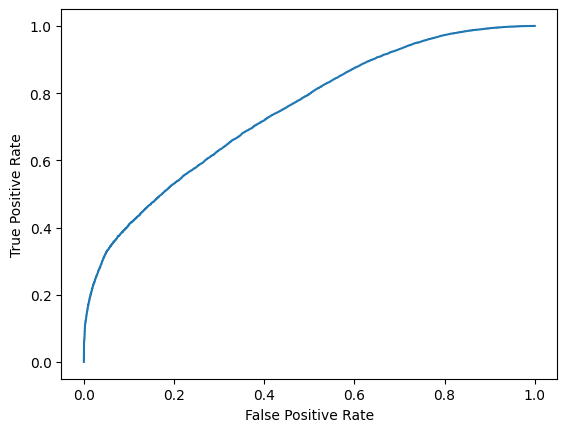

In [ ]:
import sklearn
proba = model.decision_function(pairwise_test_features)
proba

fpr, tpr, _ = sklearn.metrics.roc_curve(test_vs_actual['actual'].to_numpy(),
                                        proba)

sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
import shap; shap.initjs()

NUM_SAMPLES = 40

train_sampled = shap.utils.sample(pairwise_train_features.to_numpy(), NUM_SAMPLES)
test_sampled = shap.utils.sample(pairwise_test_features.to_numpy(), NUM_SAMPLES)

explainer = shap.KernelExplainer(model.predict, train_sampled)
shap_values = explainer.shap_values(test_sampled)
# shap_values = pd.DataFrame(shap_values,
#                            columns=pairwise_test.drop(columns=['grade_diff']).columns)

shap.force_plot(explainer.expected_value,
                shap_values,
                test_sampled,
                feature_names=[name.replace('feature.', '').replace('_diff', '')
                               for name in pairwise_test.drop(columns=['grade_diff']).columns])


  0%|          | 0/40 [00:00<?, ?it/s]